# Tutorial 1 – Protein Digestion

Welcome, molecular biotechnology students! In this first tutorial we simulate an in-silico protein digestion with various proteases.

## Learning goals for this section
- See how FASTA files act as the starting point for proteomics pipelines (database search, digestion, spectral simulation).
- Practice reading plain-text biological data in Python using simple, reproducible patterns.
- Convert a multi-protein FASTA into a dictionary (`protein_id -> sequence`) and digest those proteins with enzyme-specific regular expressions representing proteolytic cleavage sites.
- Draft the essential functions `read_fasta`, `digest_protein_sequence`, `digest_protein_collection`, and `compute_sequence_coverage` with concise documentation.
- Build habits around unit testing, data serialization (pickle), and exploratory visualization of sequence coverage across proteases.

> 💡 **Data**
> We will work with `data/sample_proteins.fasta`, a small subset of UniProt entries. FASTA is the de-facto text format for sharing nucleotide or protein sequences in bioinformatics databases, so mastering helps you work with them when you inevitably encounter them later.

---

## 1. Explore the raw FASTA file

Before we simulate protease digestion, we need a reliable way to read the protein sequences that feed the workflow. This section shows how the protein records stored in FASTA files become the input for our in-silico digestion experiments.

### 1.1 Manual inspection
Open `data/sample_proteins.fasta` in any text viewer (VS Code, nano, `less`, etc.) and inspect the contents. Can you figure out what the different lines and information mean?

<details>
<summary>FASTA file structure explained</summary>

- Headers always start with `>` and carry database-specific metadata including the entry (e.g. protein) identifier.
- The UniProt protein ID appears between the first and second `|`.
- The amino-acid sequence is found below the header.
- The sequence letters may wrap across multiple lines for readability.

A protein FASTA file therefore follows a simple repeating block:

```
>database|protein_id|entry description...
SEQUENCE_LINE_1
SEQUENCE_LINE_2
```

Each block continues until the next `>` header.
</details>

### 1.2 Load the file contents with Python
Use standard Python file reading to load the full FASTA file into a single string. Print the Python type and the first ~400 characters to make sure the text matches what you saw manually.

> 🚩 **Fill in the triple dots [...]**

In [4]:
fasta_path = '../data/sample_proteins.fasta'

# Read the file contents into a single string named `raw_fasta_text`.
with open(fasta_path, 'r') as fasta_file:
    raw_fasta_text = ...

# Print the variable type and the first few hundred characters to inspect the structure.
...

<class 'str'>
>sp|P11802|CDK4_HUMAN Cyclin-dependent kinase 4 OS=Homo sapiens OX=9606 GN=CDK4 PE=1 SV=2
MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALL
RRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDL
MRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWY
RAPEVLLQSTYATPVDMWSVGCIFAEMFRRKPLFCGNSEADQLGKIFDLIGLPPEDDWPR
DVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHKRISAFRALQHSYLHKDEG
NPE
>


### 1.3 Poke at the raw string
Split the text with `.splitlines()` and confirm that header lines begin with `>` while sequence lines do not. Count how many headers you find and note down anything interesting (e.g., blank lines, trailing spaces) that might affect parsing.

> 🚩 **Fill in the triple dots [...]**

In [5]:
lines = ...
print(f'Lines: \n')
for l in lines:
    print(l)

n_headers = ...
print(f'Nr. headers: {n_headers}')

Lines: 

>sp|P11802|CDK4_HUMAN Cyclin-dependent kinase 4 OS=Homo sapiens OX=9606 GN=CDK4 PE=1 SV=2
MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALL
RRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDL
MRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWY
RAPEVLLQSTYATPVDMWSVGCIFAEMFRRKPLFCGNSEADQLGKIFDLIGLPPEDDWPR
DVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHKRISAFRALQHSYLHKDEG
NPE
>sp|A0A087WTH1|TM265_HUMAN Transmembrane protein 265 OS=Homo sapiens GN=TMEM265 PE=3 SV=1
MEDEEKAVEILGNTEAAHPPSPIRCCWLRLRCLAATSIICGCSCLGVMALVFAIKAEERH
KAGRSEEAVRWGARARKLILASFAVWLAVLILGPLLLWLLSYAIAQAPEPTIDERE
>tr|A0A087WTH5|A0A087WTH5_HUMAN Protein LOC102723475 OS=Homo sapiens GN=LOC102723475 PE=4 SV=2
MVIEWERPRMILSNTTAVTPFLTKLWQETVQQGGNMSGLARRSPRSGDGKLEALYVLMVLGFFGFF
TLGIMLSYIRSKKLEHSNDPFNVYIESNAWQEKDKAYVQARVLESYRSCYVVENHLAIEQ
PNTHLPETKPSP
Nr. headers: 3


---

## 2. Parse the FASTA without functions
Now recreate what common bioinformatics tools do under the hood: walk through the FASTA line by line and build a dictionary that maps each UniProt identifier to its amino-acid sequence.

**FASTA file parser: algorithm**


➡️ In the next cell you get a working reference implementation. Read it carefully, run it, and then annotate each block with short `#` comments that describe what the line is doing biologically or programmatically.

In [7]:
fasta_path = '../data/sample_proteins.fasta'

protein_map = {}
current_id = None
current_sequence = []

with open(fasta_path, 'r', encoding='utf-8') as fasta_handle:
    for line in fasta_handle:
        stripped = line.strip()
        if not stripped:
            continue
        if stripped.startswith('>'):
            if current_id is not None:
                protein_map[current_id] = ''.join(current_sequence)
                current_sequence = []
            current_id = stripped.split('|')[1]
        else:
            current_sequence.append(stripped)

if current_id is not None:
    protein_map[current_id] = ''.join(current_sequence)

protein_map

{'P11802': 'MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALLRRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDLMRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWYRAPEVLLQSTYATPVDMWSVGCIFAEMFRRKPLFCGNSEADQLGKIFDLIGLPPEDDWPRDVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHKRISAFRALQHSYLHKDEGNPE',
 'A0A087WTH1': 'MEDEEKAVEILGNTEAAHPPSPIRCCWLRLRCLAATSIICGCSCLGVMALVFAIKAEERHKAGRSEEAVRWGARARKLILASFAVWLAVLILGPLLLWLLSYAIAQAPEPTIDERE',
 'A0A087WTH5': 'MVIEWERPRMILSNTTAVTPFLTKLWQETVQQGGNMSGLARRSPRSGDGKLEALYVLMVLGFFGFFTLGIMLSYIRSKKLEHSNDPFNVYIESNAWQEKDKAYVQARVLESYRSCYVVENHLAIEQPNTHLPETKPSP'}

### 2.1 Quick sanity checks
With `protein_map` filled, answer:
- How many proteins did you capture?
- What is the length of each sequence, and does it match what the FASTA advertised?
- Do any IDs repeat (they should not in this dataset)?
These checks mirror the QC steps you would run before a digestion or database search.

> 🚩 **Fill in the triple dots [...]**

In [9]:
n_proteins = ...
print(f'Total proteins: {n_proteins}')

# Print: protein_id: length of amino-acid sequence
for prot_id, seq in protein_map.items():
    print(f'{prot_id}: {...}')

# Check if any IDs repeat
if ...:
    print("All IDs are unique.")
else:
    print("Some IDs are duplicated")

Total proteins: 3
P11802: 303
A0A087WTH1: 116
A0A087WTH5: 138
All IDs are unique.


## ⭐ 3. Essential function: `read_fasta`
Package the FASTA file reader into a reusable function called `read_fasta`. Keep the input simple (`filepath` as a string), document it with a NumPy/SciPy-style docstring, and return the same dictionary structure you validated above. This function will later be copied into your package so clarity matters.

<details>
<summary> 🤖 What are NumPy/SciPy docstrings?</summary>

Modern LLMs are trained on vast amounts of code including vast amounts of documentation examples. Hence, it is a safe bet to ask them:

```
What are NumPy/SciPy docstring conventions? Give me some examples and a boilerplate to write my own function documentation.
```
</details>

> 🚩 **Fill in the triple dots [...]**

In [10]:
def read_fasta(filepath):
    """
    Add a short description here.

    Parameters
    ----------
    Returns
    -------
    """
    ...


After implementing `read_fasta`, apply it to the fasta file to confirm it matches the dictionary from Section 2. Consistency here ensures the downstream digestion steps behave exactly as expected.

> 🚩 **Fill in the triple dots [...]**

In [11]:
protein_map = ...

protein_map

{'P11802': 'MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALLRRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDLMRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWYRAPEVLLQSTYATPVDMWSVGCIFAEMFRRKPLFCGNSEADQLGKIFDLIGLPPEDDWPRDVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHKRISAFRALQHSYLHKDEGNPE',
 'A0A087WTH1': 'MEDEEKAVEILGNTEAAHPPSPIRCCWLRLRCLAATSIICGCSCLGVMALVFAIKAEERHKAGRSEEAVRWGARARKLILASFAVWLAVLILGPLLLWLLSYAIAQAPEPTIDERE',
 'A0A087WTH5': 'MVIEWERPRMILSNTTAVTPFLTKLWQETVQQGGNMSGLARRSPRSGDGKLEALYVLMVLGFFGFFTLGIMLSYIRSKKLEHSNDPFNVYIESNAWQEKDKAYVQARVLESYRSCYVVENHLAIEQPNTHLPETKPSP'}

---

## ✅ 4. Unit tests for FASTA reader
Oftentimes in bioinformatics you write code once and expect it to work in the future reliably. Code is more fragile in time than you think as there are many edge cases that could occur with different input, imported package functions change with updates and sometimes you may make small code edits with unexpected consequences. A tiny unit test protects you from subtle mistakes (for example, accidentally dropping the last protein) and ensures reproducibility. You can use plain `assert` statements — no testing framework required yet.

### 4.1 Create and test on a dummy FASTA file
First create a small FASTA file yourself containing two toy proteins and save it to `data/dummy-proteins.fasta`. Include wrapped lines or trailing blank lines so the test captures realistic formatting quirks. Remove the file afterwards if you do not want to keep it.
Then use your dummy proteins to complete the test function below.

> 🚩 **Fill in the triple dots [...]**

In [ ]:
def test_fasta_reader():
    tmp_fasta_path = '../data/dummy_proteins.fasta'
    protein_map = ...
    
    # Replace the strings with your fasta content
    # which you expect to be now available as a dictionary
    assert protein_map["PROTEIN_ID_1"] == "DUMMYSEQUENCEONE"
    assert protein_map["PROTEIN_ID_2"] == "DUMMYSEQUENCETWO"

test_fasta_reader()

✔️ If your test was effective, you expect the execution of `test_fasta_reader()` to not do anything (pass).

❌ If your test catches any assertion errors, it means that the function that you tested with your given input was not correctly implemented and didn't return your expected output. In this case you need to revisit and review your tested function.

> 💡 **Writing good unit tests**
> 
> A reliable unit test covers as many different possible input formats, types, edge cases and different function parameters, because every assertion that you test for and passes, you can rest assured that the code will work as expected.
> 
> In your minimal unit test above you can keep it simple by testing on a single input dummy fasta file.

---

🎯 **Next up:** With FASTA handling nailed down, we can safely move on to simulating protease digestion of these proteins.

---

## 5. Protein digestion

**Why do we digest proteins before LC-MS/MS?**

Whole proteins are often too large and heterogeneous to fly well in a mass spectrometer. Enzymatic digestion chops them into peptides that are:
- Easier to ionize and separate by liquid chromatography.
- Short enough to fall within the instrument’s mass/charge detection window.
- Still informative about the parent protein, because each peptide sequence maps back to a specific region.

In the wet lab, you would incubate the sample with a protease (e.g., trypsin) before loading it on the LC column. In this next section we simulate the same step so our virtual experiment mirrors reality.

### 5.1 Representing proteases with regular expressions
Each protease recognizes specific amino-acid motifs. Python’s `re` module lets us encode these motifs as regular expressions so we can *split* a protein sequence wherever a cleavage should happen.

Common examples you will see throughout the course:
- **LysC** cleaves on the C-terminal side of lysine (`K`).
- **LysN** cleaves on the N-terminal side of lysine.
- **Trypsin** cleaves on the C-terminal side of lysine or arginine, unless the next residue is proline.
- **ArgC** targets arginine specifically.

We capture these behaviors with lookbehind/lookahead regex patterns. Study the dictionary below and feel free to add more enzymes later if your project requires them.

> 🚩 **Fill in the triple dots [...]**

In [12]:
import re

enzyme_cleavage_patterns = {
    'LysC': r'(?<=K)',
    'LysN': r'(?=K)',
    'ArgC': r'(?<=R)',
    'Trypsin': ...,
}

enzyme_cleavage_patterns

{'LysC': '(?<=K)',
 'LysN': '(?=K)',
 'ArgC': '(?<=R)',
 'Trypsin': '(?<=[KR])(?!P)'}

### 5.2 Practice: digest one protein sequence
Pick a protein from `protein_map` (for example the CDK4 entry) and use `re.split` with the LysC pattern to see how many peptides you obtain.

> 🚩 **Fill in the triple dots [...]**

In [17]:
protein_id = ...
sequence = protein_map[protein_id]
cleave_pattern = enzyme_cleavage_patterns['LysC']
peptides = re.split(...)

print(peptides)
print(f'Nr. of digested peptides: {len(peptides)}')

['MATSRYEPVAEIGVGAYGTVYK', 'ARDPHSGHFVALK', 'SVRVPNGGGGGGGLPISTVREVALLRRLEAFEHPNVVRLMDVCATSRTDREIK', 'VTLVFEHVDQDLRTYLDK', 'APPPGLPAETIK', 'DLMRQFLRGLDFLHANCIVHRDLK', 'PENILVTSGGTVK', 'LADFGLARIYSYQMALTPVVVTLWYRAPEVLLQSTYATPVDMWSVGCIFAEMFRRK', 'PLFCGNSEADQLGK', 'IFDLIGLPPEDDWPRDVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHK', 'RISAFRALQHSYLHK', 'DEGNPE']
Nr. of digested peptides: 12


## ⭐ Essential function: `digest_protein_sequence`
Now let's make a reusable function for protein digestion. Write a function that accepts a protein sequence plus a cleavage pattern and returns the resulting list of peptides. Start with the basic two-argument version — `protein_seq` and `cleave_pattern` — so the logic is crystal clear before we add more options.

In [18]:
def digest_protein_sequence(protein_seq, cleave_pattern):
    """
    Function description

    Parameters
    ----------

    Returns
    -------

    """
    ...

### 5.3 Why peptide length filters matter
LC-MS/MS instruments typically detect peptides in an approximate window of 5–30 amino acids. To mimic this experimental bias we add optional length filters to our digestion function.

> 🚩 **Fill in the triple dots [...]**

In [19]:
min_length = 5
max_length = 30
filtered = [...] # list comprehension for filtering

filtered

['MATSRYEPVAEIGVGAYGTVYK',
 'ARDPHSGHFVALK',
 'VTLVFEHVDQDLRTYLDK',
 'APPPGLPAETIK',
 'DLMRQFLRGLDFLHANCIVHRDLK',
 'PENILVTSGGTVK',
 'PLFCGNSEADQLGK',
 'RISAFRALQHSYLHK',
 'DEGNPE']

### Upgrade `digest_protein_sequence` with length controls
Extend your function so it accepts `min_pep_len` and `max_pep_len` arguments (with sensible defaults). Filter the peptide list before returning it. Also think about edge cases: empty sequences, missing protein, `min_pep_len` > `max_pep_len` etc.

> 🚩 **Fill in the triple dots [...]**

In [21]:
def digest_protein_sequence(protein_seq, cleave_pattern, min_pep_len=..., max_pep_len=...):
    """
    Add a short description here.

    Parameters
    ----------
    Returns
    -------
    """
    ...

After implementing `digest_protein_sequence`, apply it to a protein sequence and a cleavage pattern of choice.

> 🚩 **Fill in the triple dots [...]**

In [22]:
seq = protein_map[...]
cleave_pattern = enzyme_cleavage_patterns[...]
digest_protein_sequence(seq, cleave_pattern=cleave_pattern, min_pep_len=..., max_pep_len=...)

['MATSRYEPVAEIGVGAYGTVYK',
 'ARDPHSGHFVALK',
 'VTLVFEHVDQDLRTYLDK',
 'APPPGLPAETIK',
 'DLMRQFLRGLDFLHANCIVHRDLK',
 'PENILVTSGGTVK',
 'PLFCGNSEADQLGK',
 'RISAFRALQHSYLHK',
 'DEGNPE']

## ⭐ Essential function: `digest_protein_collection`
Real samples contain hundreds to thousands of proteins. Let's adapt the `digest_protein_sequence` function to take a dictionary of proteins and their sequences as input and call it `digest_protein_collection`. This helper should loop over the entire `protein_map`, run `digest_protein_sequence` for each entry, and return a new dictionary: `protein_id -> list of peptides`. Keep the proposed default `min_pep_len`/`max_pep_len` values so downstream notebooks can reuse it without changes.

> 🚩 **Fill in the triple dots [...]**

In [23]:
def digest_protein_collection(protein_map, cleave_pattern, min_pep_len=5, max_pep_len=30):
    """
    Add a short description here.

    Parameters
    ----------
    Returns
    -------
    """
    ...

### Apply digestion to the entire protein set
You now have reusable helpers, so let’s generate the complete peptide pool. Pick a trypsin as the protease, run `digest_protein_collection` across `protein_map`, and store the result in `digested_peptides_map`. This mapping is the backbone for downstream coverage analyses and notebooks.

> 🚩 **Fill in the triple dots [...]**

In [25]:
cleave_pattern = ...

digested_peptides_map = digest_protein_collection(
    protein_map,
    cleave_pattern=...,
    min_pep_len=5,
    max_pep_len=30,
)

digested_peptides_map

{'P11802': ['MATSR',
  'YEPVAEIGVGAYGTVYK',
  'DPHSGHFVALK',
  'VPNGGGGGGGLPISTVR',
  'EVALLR',
  'LEAFEHPNVVR',
  'LMDVCATSR',
  'VTLVFEHVDQDLR',
  'TYLDK',
  'APPPGLPAETIK',
  'GLDFLHANCIVHR',
  'DLKPENILVTSGGTVK',
  'LADFGLAR',
  'IYSYQMALTPVVVTLWYR',
  'APEVLLQSTYATPVDMWSVGCIFAEMFR',
  'KPLFCGNSEADQLGK',
  'IFDLIGLPPEDDWPR',
  'DVSLPR',
  'GAFPPR',
  'GPRPVQSVVPEMEESGAQLLLEMLTFNPHK',
  'ISAFR',
  'ALQHSYLHK',
  'DEGNPE'],
 'A0A087WTH1': ['MEDEEK',
  'AVEILGNTEAAHPPSPIR',
  'CCWLR',
  'CLAATSIICGCSCLGVMALVFAIK',
  'SEEAVR'],
 'A0A087WTH5': ['MVIEWERPR',
  'MILSNTTAVTPFLTK',
  'LWQETVQQGGNMSGLAR',
  'SGDGK',
  'LEALYVLMVLGFFGFFTLGIMLSYIR',
  'LEHSNDPFNVYIESNAWQEK',
  'AYVQAR',
  'VLESYR',
  'SCYVVENHLAIEQPNTHLPETKPSP']}

How many peptides result from the digestion of each protein?
> 🚩 **Fill in the triple dots [...]**

In [26]:
for prot, peps in digested_peptides_map.items():
    print(f'{prot}: {...}')

P11802: 23
A0A087WTH1: 5
A0A087WTH5: 9


### ✅ Test the collection helper
Now write a unit test for the `digest_protein_collection` function. To this end create a dictionary of dummy proteins and their sequences and test for your expected results.

> 🚩 **Fill in the triple dots [...]**

In [28]:

def test_digest_protein_collection(dummy_proteins):
    dummy_proteins = {
        ...: ...
    }

    assert ...

test_digest_protein_collection()

---

## 6. Sequence coverage after digestion
Peptide identification is only as good as the coverage it provides across the original protein. Sequence coverage tells you what fraction of residues are represented by at least one detected peptide. In a biological context, higher coverage increases confidence that the protein is truly present.

### 6.1 Manual reasoning
Pick a protein (e.g., CDK4) and its peptide list from `digest_protein_collection`. Design your own algorithm to compute the protein coverage. Whatever approach you choose, explain it briefly in the notebook so future you (or a lab mate) can follow the logic.

## ⭐ Essential function: `compute_sequence_coverage`
Write a function that reports the coverage percentage for any protein/peptide combination. Keep the return value as a floating-point percentage (0–100).

> 🚩 **Fill in the triple dots [...]**

In [29]:
def compute_sequence_coverage(protein_seq, peptides):
    """
    Add a short description here.

    Parameters
    ----------
    Returns
    -------
    """
    ...
    

Apply your function to a protein of choice and its digested peptides.

In [30]:
prot_seq = ...
peps = ...

compute_sequence_coverage(prot_seq, peps)

92.73927392739274

### ✅ Quick unit test (sequence coverage)

Create a unit test for `compute_sequence_coverage` by creating a dummy input protein sequence and digested peptides list and asserting that the result is what you expect.

> 🚩 **Fill in the triple dots [...]**

In [31]:
def test_compute_sequence_coverage():
    dummy_prot_seq = ...
    dummy_peps = ...

    coverage = ...
    assert coverage == ...

test_compute_sequence_coverage()

---

## 7. Save the digested peptide map
Keep your digestion results handy for future tutorials. Store `digested_peptides_map` as a pickle file so you can reload it without repeating the computation.

### 7.1 Write to disk
Use the built-in `pickle` module to serialize the dictionary. Saving to `results/digested_peptides_map.pkl` keeps outputs centralized.

> 🚩 **Fill in the triple dots [...]**

In [35]:
import pickle
output_path = '../results/digested_peptides_map.pkl'

with open(output_path, 'wb') as file:
    pickle.dump(...)

---

## 8. Protease-wide comparison
Different enzymes sample different parts of each protein. To pick the best digestion strategy, let’s compute sequence coverage for **every protease** in `enzyme_cleavage_patterns` and for **every protein** in `protein_map`. We will summarize the results in a pandas `DataFrame` so they are easy to compare and plot.

### 8.1 Build the coverage table
For each protease:
1. Digest all proteins with `digest_protein_collection`.
2. Compute sequence coverage for every protein using `compute_sequence_coverage`.
3. Store the results in a list of dictionaries such as `{
   'protease': 'Trypsin',
   'protein_id': 'CDK4',
   'coverage_pct': 78.5
}`.
4. Convert the list into a pandas `DataFrame`.

This table will reveal how enzyme choice influences the observable portion of each protein.

> 🚩 **Fill in the triple dots [...]**

In [36]:
import pandas as pd

...

,protease,protein_id,coverage_pct
0,LysC,P11802,45.214521
1,LysC,A0A087WTH1,24.137931
2,LysC,A0A087WTH5,71.014493
3,LysN,P11802,45.214521
4,LysN,A0A087WTH1,23.275862
5,LysN,A0A087WTH5,70.289855
6,ArgC,P11802,96.039604
7,ArgC,A0A087WTH1,58.620690
8,ArgC,A0A087WTH5,27.536232
9,Trypsin,P11802,92.739274


### 8.2 Visualize with a boxplot
Use the DataFrame to produce a boxplot comparing coverage distributions across proteases (e.g., `coverage_df.boxplot(column='coverage_pct', by='protease')`). This mimics how you would quickly evaluate digestion strategies before committing to a wet-lab protocol.

> 🚩 **Fill in the triple dots [...]**

<Figure size 720x432 with 0 Axes>

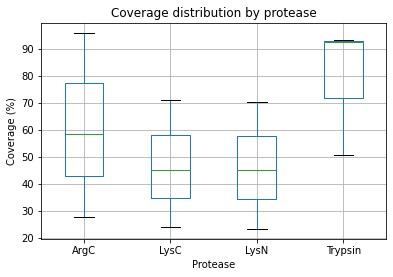

In [37]:
...

### Reflection questions
- Which enzyme gives the highest sequence coverage across proteins?
- How might the choice of enzyme affect the quality and interpretability of MS data?
- Is the same enzyme good for all proteins? Explain your reasoning based on the plot.

---

## Summary
Today, you learned how to:
- FASTA file handling.
- Simulate protein digestion using regular expressions to model enzyme-specific cleavage.
- ⭐ Write flexible Python functions with multiple inputs and documentation.
- Write loops, use list comprehensions, and handle dictionaries.
- Create a pandas DataFrame and make a simple plot using Matplotlib or Seaborn.
- ✅ Unit testing to protect your workflow.